# Efecto de las características de adaptación de una neurona AdEx.

Segundo caso: Varío el tiempo de adaptación y el peso de la sinapsis.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
import nest
nest.Install('scmodule')
nest.SetKernelStatus({"resolution": 0.01})

In [2]:
num_neurons = 1
num_neu_sc = 3
sigma = 8 #ms

Creo las poblaciones para el generador, la capa de entrada y la de SC, cada una cos sus parámetro pertinentes.

In [3]:
GEN_dict={"i0":3.0, "beta":0.03, "gamma":1.8, "pop":0.5, "sc_onset":0.0, "distance":0.0}
GEN_pop = nest.Create("sc_generator", num_neurons, params=GEN_dict)

In [4]:
FEF_dict = {"C_m":50.0,"t_ref":0.0,"V_reset":-55.0,"E_L":-70.0, "g_L":2.0, "I_e":0.0, "a":0.0, "b":60.0, 
            "Delta_T":2.0, "tau_w":30.0, "V_th":-50.0, "V_peak":-30.0}
FEF_pop = nest.Create("aeif_cond_exp", num_neurons, params=FEF_dict)

Varío la constante de tiempo de adaptación.

In [5]:
tau_w = [66.3, 44.8, 23.4]
SC_list = []
for tau in tau_w:
    SC_list.append({"C_m":280.0,"t_ref":0.0, "V_reset":-45.0, "E_L":-70.0, "g_L":10.0,"I_e":0.0, "a":4.0,
                    "b":80.0, "Delta_T":2.0,"V_th":-50.0, "V_peak":-30.0,"E_ex":0.0, "tau_syn_ex":5.0,
                    "E_in":-80.0, "tau_syn_in":10.0, "tau_w":tau}) 
SC_pop=nest.Create("aeif_cond_exp",num_neu_sc, params=SC_list)

In [6]:
nest.Connect(GEN_pop, FEF_pop, "one_to_one", syn_spec={'weight':1.0})

Varío el peso y asigno uno a cada una de las constantes de tiempo.

In [7]:
#hacer con vectores
nest.Connect(FEF_pop, [SC_pop[0]], "one_to_one",  syn_spec={'weight':15.0})
nest.Connect(FEF_pop, [SC_pop[1]], "one_to_one",  syn_spec={'weight':13.0})
nest.Connect(FEF_pop, [SC_pop[2]], "one_to_one",  syn_spec={'weight':9.3})

Conecto un multímtro y un detector de spikes que me permitan realizar las mediciones.

In [8]:
multimeter = nest.Create("multimeter", params={"withtime":True, "record_from":["V_m", "w"], 'interval' :0.1})
nest.Connect(multimeter, SC_pop)

spikedetector = nest.Create("spike_detector", params={"withgid":True, "withtime":True})
nest.Connect(SC_pop, spikedetector)

In [9]:
nest.Simulate(200.0)

<IPython.core.display.Javascript object>


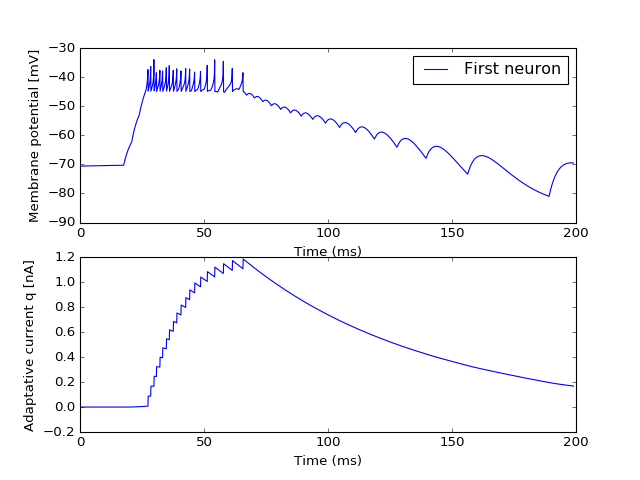

<IPython.core.display.Javascript object>


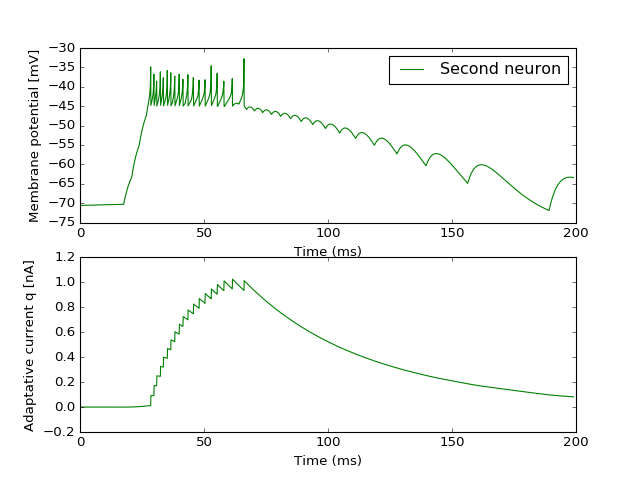

<IPython.core.display.Javascript object>


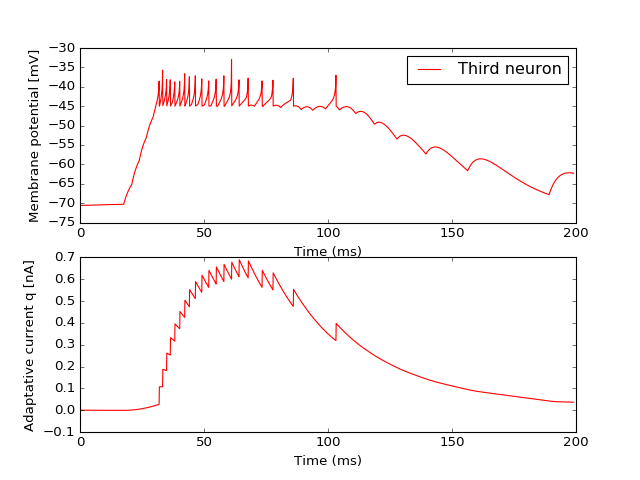

In [15]:
dmm=nest.GetStatus(multimeter)[0]
Vms=dmm["events"]["V_m"]
ts=dmm["events"]["times"]
neuronid = dmm["events"]["senders"]
q=dmm["events"]["w"]
q=q*1e-3

#Primera neurona de SC_pop
plt.figure(1)
plt.subplot(211)
plt.plot(ts[neuronid==SC_pop[0]], Vms[neuronid==SC_pop[0]], 'b')
plt.ylabel('Membrane potential [mV]')
plt.xlabel('Time (ms)')
plt.legend(['First neuron'])
plt.subplot(212)
plt.plot(ts[neuronid==SC_pop[0]], q[neuronid==SC_pop[0]], 'b')
plt.ylabel('Adaptative current q [nA]')
plt.xlabel('Time (ms)')

#Segunda neurona de SC_pop
plt.figure(2)
plt.subplot(211)
plt.plot(ts[neuronid==SC_pop[1]], Vms[neuronid==SC_pop[1]], 'g')
plt.ylabel('Membrane potential [mV]')
plt.xlabel('Time (ms)')
plt.legend(['Second neuron'])
plt.subplot(212)
plt.plot(ts[neuronid==SC_pop[1]], q[neuronid==SC_pop[1]], 'g')
plt.ylabel('Adaptative current q [nA]')
plt.xlabel('Time (ms)')

#Tercera neurona de SC_pop
plt.figure(3)
plt.subplot(211)
plt.plot(ts[neuronid==SC_pop[2]], Vms[neuronid==SC_pop[2]], 'r')
plt.ylabel('Membrane potential [mV]')
plt.xlabel('Time (ms)')
plt.legend(['Third neuron'])
plt.subplot(212)
plt.plot(ts[neuronid==SC_pop[2]], q[neuronid==SC_pop[2]], 'r')
plt.ylabel('Adaptative current q [nA]')
plt.xlabel('Time (ms)')

Fig.8. Evolución temporal de las variables de estado (potencial de membrana y corrientede adaptación), variando el tiempo de adaptación y el paso de la sinapsis.

In [11]:
#spikedetector
dSD = nest.GetStatus(spikedetector)[0]
evs = dSD["events"]["senders"]
tspk = dSD["events"]["times"]

Utilizo de nuevo la gaussiana para calcular las densidades de los spikes.

In [12]:
def gaussian_funct(time_diff, sigma):
    return (1/(sigma*numpy.sqrt(2*numpy.pi))*numpy.exp(-(time_diff*time_diff)/(2*(sigma*sigma))))

In [13]:
t = numpy.arange(0.0,300.0,0.1)
gauss = numpy.zeros((len(SC_pop),t.shape[0]))
for idx,neurid in enumerate(SC_pop):    
    selected = (evs==neurid)
    for spike in tspk[selected]:        
        time_diff = t-spike
        gauss[idx,:] = gauss[idx,:]+(gaussian_funct(time_diff, sigma))
gauss = gauss*1e3

<IPython.core.display.Javascript object>


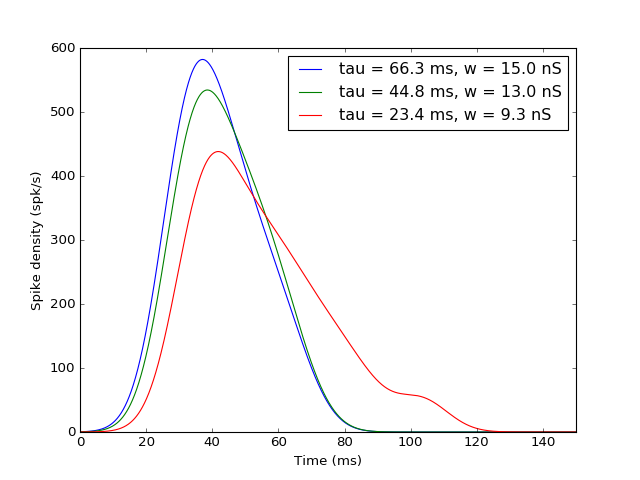

In [14]:
plt.figure(4)
plt.xlim([0,150])
plt.plot(t, gauss.T)
plt.xlabel('Time (ms)')
plt.ylabel('Spike density (spk/s)')
plt.legend(['tau = 66.3 ms, w = 15.0 nS', 'tau = 44.8 ms, w = 13.0 nS', 'tau = 23.4 ms, w = 9.3 nS'])

Fig.9. Función de densidad de los spikes variando los pesos sinápticos.